In [1]:
 %pip install python-dotenv 

Note: you may need to restart the kernel to use updated packages.


In [33]:
import requests
import pandas as pd 
from typing import Dict, List, Optional
from bs4 import BeautifulSoup
import os
from dotenv import load_dotenv
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler

API_KEY= os.getenv('YELP_API_KEY')
HEADERS = { 'Authorization':f'Bearer {API_KEY}'}
DAYS = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]

In [3]:
url = 'https://api.yelp.com/v3/businesses/search'

In [4]:
params = {
    "term": "Village - The Soul of India",
    "location": "Hicksville, NY",
    "limit": 1
}

In [5]:
response = requests.get(url, headers=HEADERS, params=params)

In [6]:
if response.status_code == 200:
    data = response.json()
    if data["businesses"]:
        restaurant = data["businesses"][0]
        business_id = restaurant["id"]
        
        details_url = f"https://api.yelp.com/v3/businesses/{business_id}"
        details_response = requests.get(details_url, headers=HEADERS)

        if details_response.status_code == 200:
            details = details_response.json()
            print("Name:", details["name"])
            print("Address:", ", ".join(details["location"]["display_address"]))
            print("Phone:", details["phone"])
            print("Rating:", details["rating"])

            # Fetch hours of operation
            if "hours" in details:
                for day in details["hours"][0]["open"]:
                    print(f"Day {day['day']}: {day['start']} - {day['end']}")
            else:
                print("Open/Close Times: N/A")
        else:
            print("Error fetching business details:", details_response.status_code)
    else:
        print("No business found.")
else:
    print("Error:", response.status_code, response.json())

Name: Village the soul of india
Address: 11 West Marie St, Hicksville, NY 11801
Phone: +15168590057
Rating: 4.8
Day 0: 1100 - 1500
Day 0: 1700 - 2200
Day 2: 1100 - 1500
Day 2: 1700 - 2200
Day 3: 1100 - 1500
Day 3: 1700 - 2200
Day 4: 1100 - 1500
Day 4: 1700 - 2200
Day 5: 1130 - 2200
Day 6: 1130 - 2200


Function to format time from yelp api time 

In [7]:
def format_time(time_str):
    # Assume time_str is in HHMM format (24-hour)
    hour = int(time_str[:2])
    minute = time_str[2:]

    # Convert to 12-hour format
    suffix = "AM" if hour < 12 else "PM"
    hour = hour % 12
    if hour == 0:
        hour = 12

    return f"{hour}:{minute} {suffix}"


In [ ]:
if response.status_code == 200:
    data = response.json()
    if data["businesses"]:
        restaurant = data["businesses"][0]
        business_id = restaurant["id"]

        #Fetch detailed business information including hours
        details_url = f"https://api.yelp.com/v3/businesses/{business_id}"
        details_response = requests.get(details_url, headers=HEADERS)

        if details_response.status_code == 200:
            details = details_response.json()
            print("Name:", details["name"])
            print("Address:", ", ".join(details["location"]["display_address"]))
            print("Phone:", details["phone"])
            print("Rating:", details["rating"])
            

            #format hours of operation
            if "hours" in details:
                for day_hours in details["hours"][0]["open"]:
                    DAYS = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
                    day_name = DAYS[day_hours["day"]]
                    start_time = format_time(day_hours["start"])
                    end_time = format_time(day_hours["end"])
                    print(f"{day_name}: {start_time} - {end_time}")
            else:
                print(f"Closed on{day}")
        else:
            print("Error fetching business details:", details_response.status_code)
    else:
        print("No business found.")
else:
    print("Error:", response.status_code, response.json())




Name: Village the soul of india
Address: 11 West Marie St, Hicksville, NY 11801
Phone: +15168590057
Rating: 4.8
Monday: 11:00 AM - 3:00 PM
Monday: 5:00 PM - 10:00 PM
Wednesday: 11:00 AM - 3:00 PM
Wednesday: 5:00 PM - 10:00 PM
Thursday: 11:00 AM - 3:00 PM
Thursday: 5:00 PM - 10:00 PM
Friday: 11:00 AM - 3:00 PM
Friday: 5:00 PM - 10:00 PM
Saturday: 11:30 AM - 10:00 PM
Sunday: 11:30 AM - 10:00 PM


In [9]:
params_for_top5 = {
    "term": "Indian ",  
    "location": "Hicksville, NY",  
    "radius": 2000,  
    "limit": 6,  
    "sort_by": "rating",  
}


response = requests.get(url, headers=HEADERS, params=params_for_top5)


if response.status_code == 200:
    data = response.json()
    if data["businesses"]:
        print("Top 5 Restaurants Within 2 km from Village:")
        for restaurant in data["businesses"]:
            name = restaurant["name"]
            if "Village" in name:
                continue
            
            address = ", ".join(restaurant["location"]["display_address"])
            rating = restaurant["rating"]
            phone = restaurant.get("phone", "N/A")
            print(f"Name: {name}")
            print(f"Address: {address}")
            print(f"Rating: {rating}")
            print(f"Phone: {phone}")
            print("-" * 40)
    else:
        print("No nearby restaurants found.")
else:
    print("Error:", response.status_code, response.json())


Top 5 Restaurants Within 2 km from Village:
Name: Kunga Kitchen
Address: 390 Woodbury Rd, Hicksville, NY 11801
Rating: 4.6
Phone: +15164905501
----------------------------------------
Name: Taste of Mumbai
Address: 153 Levittown Pkwy, Hicksville, NY 11801
Rating: 4.6
Phone: +15162619070
----------------------------------------
Name: Kabul Grill
Address: 129 N Broadway, Hicksville, NY 11801
Rating: 4.5
Phone: +15169338999
----------------------------------------
Name: Hamza & Madina Halal Food
Address: 217 Bethpage Rd, Ste 27, Hicksville, NY 11801
Rating: 4.5
Phone: +15165266006
----------------------------------------
Name: Kathis & Kababs
Address: 55 Broadway, Ste A, Hicksville, NY 11801
Rating: 4.4
Phone: +15165957775
----------------------------------------


Function for Scraping Menu Item and Prices with BeautifulSoup

In [10]:
def extract_menu(restaurant_url):
    response = requests.get(restaurant_url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, "html.parser")
       
        sections = soup.find_all("h2", class_="alternate") 
        
        menu = {}
        for section in sections:
            section_title = section.text.strip()
            menu_items = section.find_next("div", class_="u-space-b3").find_all("div", class_="menu-item")
            
            items = []
            for item in menu_items:
                h4_name = item.find("h4").text.strip() if item.find("h4") else "N/A"
                price = item.find("div", class_="menu-item-prices arrange_unit")
                price = price.text.strip() if price else "N/A"
                items.append({"item": h4_name, "price": price})
            
            menu[section_title] = items
        
        return menu
    else:
        print(f"Failed to fetch menu for {restaurant_url}")
        return None


Menu of Village 

In [11]:
village_url = "https://www.yelp.com/menu/village-the-soul-of-india-hicksville"  # Replace with actual URL of menu
village_menu = extract_menu(village_url)

if village_menu:
    print("Menu for Village the Soul of India:")
    for section, items in village_menu.items():
        print(f"\n{section}:")
        for item in items:
            print(f" - {item['item']} - {item['price']}")

Menu for Village the Soul of India:

Appetizers:
 - Medu Vada - $6.00
 - Medu Vada in Sambar Bowl - $6.99
 - Medu Vada in Rasam Bowl - $6.99
 - Combo - $5.99
 - Combo in Sambar Bowl - $6.99
 - Masala Vada - $7.45
 - Dahi Vada - $8.95
 - Batata Vada - $6.00
 - Mysore Bonda - $6.00
 - Chennai Pakkoda - $6.00
 - Spring Rolls - $7.45
 - Paneer Pakkoda - $8.95
 - Samosa - $6.00
 - Aloo Tikki - $6.00
 - Chilly Pakora - $6.00

Soups and Salad:
 - Tomato Soup - $7.45
 - Vegetables Manchow Soup - $7.45
 - Rasam - $7.45
 - Sambar - $7.45
 - Mulligatawny Soup - $7.45
 - Garden Soup - $7.45
 - Katchumbar Salad - $7.45
 - Garden Salad - $7.45

Idlys:
 - Idly - $7.45
 - Masala Idly - $9.95
 - Mini Idly - $7.45
 - Ghee Fried Idly - $9.95
 - Podi Idly - $8.95
 - Chilli Idly - $9.95
 - Idly in Sambar Bow - $8.95
 - Idly Rasam Bowl - $8.95
 - Dami Idly - $7.45

Village Chats:
 - Bhel Puri - $8.95
 - Samosa Chat - $8.95
 - Aloo Tikki Chat - $9.95
 - Papdee Chat - $8.95
 - Dahi Bhalla - $8.95
 - Channa Ch

In [12]:
def display_menu(menu):
    if menu:
        print("Menu for Village the Soul of India:")
        for section, items in menu.items():
            print(f"\n{section}:")
            for item in items:
                print(f" - {item['item']} - {item['price']}")
    else:
        print("No menu found for Village the Soul of India.")
print(display_menu(village_menu))

Menu for Village the Soul of India:

Appetizers:
 - Medu Vada - $6.00
 - Medu Vada in Sambar Bowl - $6.99
 - Medu Vada in Rasam Bowl - $6.99
 - Combo - $5.99
 - Combo in Sambar Bowl - $6.99
 - Masala Vada - $7.45
 - Dahi Vada - $8.95
 - Batata Vada - $6.00
 - Mysore Bonda - $6.00
 - Chennai Pakkoda - $6.00
 - Spring Rolls - $7.45
 - Paneer Pakkoda - $8.95
 - Samosa - $6.00
 - Aloo Tikki - $6.00
 - Chilly Pakora - $6.00

Soups and Salad:
 - Tomato Soup - $7.45
 - Vegetables Manchow Soup - $7.45
 - Rasam - $7.45
 - Sambar - $7.45
 - Mulligatawny Soup - $7.45
 - Garden Soup - $7.45
 - Katchumbar Salad - $7.45
 - Garden Salad - $7.45

Idlys:
 - Idly - $7.45
 - Masala Idly - $9.95
 - Mini Idly - $7.45
 - Ghee Fried Idly - $9.95
 - Podi Idly - $8.95
 - Chilli Idly - $9.95
 - Idly in Sambar Bow - $8.95
 - Idly Rasam Bowl - $8.95
 - Dami Idly - $7.45

Village Chats:
 - Bhel Puri - $8.95
 - Samosa Chat - $8.95
 - Aloo Tikki Chat - $9.95
 - Papdee Chat - $8.95
 - Dahi Bhalla - $8.95
 - Channa Ch

In [13]:
print(village_menu)

{'Appetizers': [{'item': 'Medu Vada', 'price': '$6.00'}, {'item': 'Medu Vada in Sambar Bowl', 'price': '$6.99'}, {'item': 'Medu Vada in Rasam Bowl', 'price': '$6.99'}, {'item': 'Combo', 'price': '$5.99'}, {'item': 'Combo in Sambar Bowl', 'price': '$6.99'}, {'item': 'Masala Vada', 'price': '$7.45'}, {'item': 'Dahi Vada', 'price': '$8.95'}, {'item': 'Batata Vada', 'price': '$6.00'}, {'item': 'Mysore Bonda', 'price': '$6.00'}, {'item': 'Chennai Pakkoda', 'price': '$6.00'}, {'item': 'Spring Rolls', 'price': '$7.45'}, {'item': 'Paneer Pakkoda', 'price': '$8.95'}, {'item': 'Samosa', 'price': '$6.00'}, {'item': 'Aloo Tikki', 'price': '$6.00'}, {'item': 'Chilly Pakora', 'price': '$6.00'}], 'Soups and Salad': [{'item': 'Tomato Soup', 'price': '$7.45'}, {'item': 'Vegetables Manchow Soup', 'price': '$7.45'}, {'item': 'Rasam', 'price': '$7.45'}, {'item': 'Sambar', 'price': '$7.45'}, {'item': 'Mulligatawny Soup', 'price': '$7.45'}, {'item': 'Garden Soup', 'price': '$7.45'}, {'item': 'Katchumbar Sal

Menu of Competitors

In [ ]:

restaurants = [
      # Replace with actual URL
    {"name": "Kunga Kitchen", "url": "https://www.yelp.com/menu/kunga-kitchen-hicksville"},
    {"name": "Taste of Mumbai", "url": "https://www.yelp.com/menu/taste-of-mumbai-hicksville-3"},
    {"name": "Kathis & Kababs", "url": "https://www.yelp.com/menu/kathis-and-kababs-hicksville"},
    {"name": "Kabul Grill", "url": "https://www.yelp.com/menu/kabul-grill-hicksville-2"},
    {"name": "Taste Of Chennai", "url": "https://www.yelp.com/menu/taste-of-chennai-hicksville"}
    
]


# Extract menu for each restaurant
def display_similar_menu():
    
    
    for restaurant in restaurants:
        print(f"\nFetching menu for {restaurant['name']}...")
        menu = extract_menu(restaurant['url'])
        
        if menu:
            print(f"Menu for {restaurant['name']}:")
            for section, items in menu.items():
                print(f"\n{section}:")
                for item in items:
                    print(f" - {item['item']} - {item['price']}")
        else:
            print(f"Failed to fetch menu for {restaurant['name']}")
    return menu
            
similar_menu = display_similar_menu()


Fetching menu for Kunga Kitchen...
Menu for Kunga Kitchen:

APPETIZERS:
 - CHILLI FISH DRY - $15.59
 - CHILLI SHRIMP DRY - $15.59
 - VEG SAMOSA - $5.19
 - VEG SPRING ROLL - $7.27
 - CHICKEN SPRING ROLL - $7.27
 - CHICKEN TIKKA - $15.59
 - CHICKEN SEEKH KABAB - $13.51
 - CAULIFLOWER MANCHURIAN DRY - $9.35
 - MASALA FRENCH FRIES - $7.27
 - CRISPY HONEY LOTUS - $10.39
 - VEG MANCHURIAN DRY - $9.35
 - CRISPY CHILLI LOTUS - $10.39
 - VEG STEAM DUMPLING - $9.35
 - CHICKEN STEAM DUMPLING - $10.39
 - VEG FRIED DUMPLING - $9.35
 - CHICKEN FRIED DUMPLING - $10.39
 - KAI CHI - CHICKEN WINGS - $12.47
 - HONEY CHICKEN DRY - $10.39
 - PAPAYA SALAD - $7.27
 - CHILLI PANEER DRY - $10.39
 - CHICKEN MANCHURIAN DRY - $10.39
 - HAKKA CHILLI CHICKEN DRY - $11.43

SOUP:
 - MANCHOW SOUP - $2.16
 - TOM YAM SOUP - $2.16
 - HOT & SOUR SOUP - $2.16
 - SWEET CORN SOUP - $2.16
 - SPICY LEMON CORIANDER SOUP - $2.16
 - BENGALI STYLE THAI SOUP - $2.16

INDIAN ENTREES:
 - BUTTER CHICKEN - $16.63
 - CHICKEN KORMA - $1

* DETAILED SIMILARITY COMPARISON

In [15]:
import requests
from bs4 import BeautifulSoup
import re


def extract_menu25(restaurant_url):
    response = requests.get(restaurant_url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, "html.parser")
        sections = soup.find_all("h2", class_="alternate")
        menu = {}
        for section in sections:
            section_title = section.text.strip()
            menu_items = section.find_next("div", class_="u-space-b3").find_all("div", class_="menu-item")
            items = []
            for item in menu_items:
                h4_name = item.find("h4").text.strip() if item.find("h4") else "N/A"
                price = item.find("div", class_="menu-item-prices arrange_unit")
                price = price.text.strip() if price else "N/A"
                items.append({"item": h4_name, "price": price})
            menu[section_title] = items
        return menu
    else:
        print(f"Failed to fetch menu for {restaurant_url}")
        return None

def get_restaurant_menus(restaurants):
    all_menus = {}
    for restaurant in restaurants:
        menu = extract_menu25(restaurant["url"])
        if menu:
            all_menus[restaurant["name"]] = menu
    return all_menus

def compare_prices_and_show_cheapest(village_menu_test2, nearby_menus):
    lowest_prices = {}

    for section, items in village_menu_test2.items():
        print(f"\nChecking Section: {section}")

        for item in items:
            print(f"Checking item: {item}")

            if isinstance(item, dict):
                item_name = item['item'].strip().lower()  # Normalize the item name
                village_price = item['price']
                try:
                    village_price_value = float(village_price.strip('$'))  # Get the price from Village
                except ValueError:
                    village_price_value = None  # If the price format is invalid

                # Store information about this item
                item_info = {
                    'item': item_name,
                    'village_price': village_price_value,
                    'village_restaurant': "Village the Soul of India",
                    'matching_restaurants': []
                }

                # Look for this item in the nearby menus
                for nearby_restaurant in nearby_menus:
                    print(f"Checking menu from {nearby_restaurant['name']}")
                    nearby_menu = nearby_restaurant['menu']

                    if section in nearby_menu:
                        for nearby_item in nearby_menu[section]:
                            if isinstance(nearby_item, dict):
                                nearby_item_name = nearby_item['item'].strip().lower()  # Normalize the name
                                if item_name == nearby_item_name:  # Check if the names match
                                    nearby_price = nearby_item['price']
                                    try:
                                        nearby_price_value = float(nearby_price.strip('$'))  # Get nearby price
                                        item_info['matching_restaurants'].append({
                                            'restaurant': nearby_restaurant['name'],
                                            'price': nearby_price_value
                                        })
                                    except ValueError:
                                        print(f"Invalid price format for item '{item_name}' at {nearby_restaurant['name']}.")

                # After collecting all matching restaurants, check for the cheapest
                if item_info['matching_restaurants']:
                    item_info['matching_restaurants'].append({
                        'restaurant': "Village the Soul of India",
                        'price': village_price_value
                    })

                    # Find the cheapest price
                    cheapest = min(item_info['matching_restaurants'], key=lambda x: x['price'])
                    print(f"Item: {item_name.capitalize()} - Price at Village: ${village_price_value:.2f}")
                    print(f"Similarity found in: ", end="")
                    for res in item_info['matching_restaurants']:
                        print(f"{res['restaurant']} - ${res['price']:.2f}", end=", ")
                    print(f"\nCheapest: ${cheapest['price']:.2f} at {cheapest['restaurant']}")
                    print("-" * 50)

                    # Store the result for later use
                    lowest_prices[item_name] = {
                        'cheapest_restaurant': cheapest['restaurant'],
                        'lowest_price': f"${cheapest['price']:.2f}",
                        'matching_restaurants': item_info['matching_restaurants']
                    }
                else:
                    print(f"Item '{item_name.capitalize()}' not found in any nearby menus.")

    return lowest_prices


# Define your list of restaurants
restaurants_test = [
      # Replace with actual URL
    {"name": "Village the soul of india", "url": "https://www.yelp.com/menu/village-the-soul-of-india-hicksville"},  
    {"name": "Kunga Kitchen", "url": "https://www.yelp.com/menu/kunga-kitchen-hicksville"},
    {"name": "Taste of Mumbai", "url": "https://www.yelp.com/menu/taste-of-mumbai-hicksville-3"},
    {"name": "Kathis & Kababs", "url": "https://www.yelp.com/menu/kathis-and-kababs-hicksville"},
    {"name": "Kabul Grill", "url": "https://www.yelp.com/menu/kabul-grill-hicksville-2"},
    {"name": "Taste Of Chennai", "url": "https://www.yelp.com/menu/taste-of-chennai-hicksville"}
    
]

# Get all the restaurant menus
all_menus = get_restaurant_menus(restaurants_test)

# Extract the Village menu
village_menu_test2 = all_menus.get("Village the Soul of India", {})

# Extract the menus of nearby restaurants
nearby_menus2 = [
    {"name": "Kunga Kitchen", "menu": all_menus.get("Kunga Kitchen", {})},
    {"name": "Taste of Mumbai", "menu": all_menus.get("Taste of Mumbai", {})},
    {"name": "Kathis & Kababs", "menu": all_menus.get("Kathis & Kababs", {})},
    {"name": "Kabul Grill", "menu": all_menus.get("Kabul Grill", {})},
    {"name": "Taste Of Chennai", "menu": all_menus.get("Taste Of Chennai", {})}
    
    
]

print(f"Village Menu: {village_menu}")
print(f"Nearby Menus: {nearby_menus2}")

# Compare prices and find the cheapest options
lowest_prices = compare_prices_and_show_cheapest(village_menu, nearby_menus2)




# Print the lowest prices
print("Lowest Prices for Menu Items:")
for item_name, details in lowest_prices.items():
    print(f"{item_name}: {details['cheapest_restaurant']} - {details['lowest_price']}")


Village Menu: {'Appetizers': [{'item': 'Medu Vada', 'price': '$6.00'}, {'item': 'Medu Vada in Sambar Bowl', 'price': '$6.99'}, {'item': 'Medu Vada in Rasam Bowl', 'price': '$6.99'}, {'item': 'Combo', 'price': '$5.99'}, {'item': 'Combo in Sambar Bowl', 'price': '$6.99'}, {'item': 'Masala Vada', 'price': '$7.45'}, {'item': 'Dahi Vada', 'price': '$8.95'}, {'item': 'Batata Vada', 'price': '$6.00'}, {'item': 'Mysore Bonda', 'price': '$6.00'}, {'item': 'Chennai Pakkoda', 'price': '$6.00'}, {'item': 'Spring Rolls', 'price': '$7.45'}, {'item': 'Paneer Pakkoda', 'price': '$8.95'}, {'item': 'Samosa', 'price': '$6.00'}, {'item': 'Aloo Tikki', 'price': '$6.00'}, {'item': 'Chilly Pakora', 'price': '$6.00'}], 'Soups and Salad': [{'item': 'Tomato Soup', 'price': '$7.45'}, {'item': 'Vegetables Manchow Soup', 'price': '$7.45'}, {'item': 'Rasam', 'price': '$7.45'}, {'item': 'Sambar', 'price': '$7.45'}, {'item': 'Mulligatawny Soup', 'price': '$7.45'}, {'item': 'Garden Soup', 'price': '$7.45'}, {'item': '

Busiest Hour of the Village Restaurant:

In [16]:
import datetime

# Manually input busy times or Access PopularTimes API
busy_times = {
    "Monday": {"start": "19:00", "end": "20:00"},    
    "Wednesday": {"start": "19:00", "end": "20:00"},
    "Thursday": {"start": "19:00", "end": "20:00"},
    "Friday": {"start": "19:00", "end": "20:00"},
    "Saturday": {"start": "19:00", "end": "21:00"},
    "Sunday": {"start": "17:00", "end": "20:00"},
}

# Get the current day and time
now = datetime.datetime.now()
current_day = now.strftime("%A")  # Current day of the week (e.g., Monday)
current_time = now.strftime("%H:%M")  # Current time in 24-hour format (e.g., 19:30)

# Check if it's a busy time
busy_start = busy_times[current_day]["start"]
busy_end = busy_times[current_day]["end"]

# Compare current time with busy period
if busy_start <= current_time <= busy_end:
    print(f"It is currently a busy time at the restaurant ({current_day} between {busy_start} and {busy_end}).")
else:
    print(f"It is not a busy time at the restaurant ({current_day}).")


It is not a busy time at the restaurant (Monday).


Current Temperature near Village


In [17]:
import requests

#weather data api key   
api_key = os.getenv('WEATHER_API_KEY')
city = "Hicksville"
#imperial units returns Temperature in Farenheit 
url_for_temperature = f"http://api.openweathermap.org/data/2.5/weather?q={city}&appid={api_key}&units=imperial"

response = requests.get(url_for_temperature)
data = response.json()

weather = data['weather'][0]['description']
temperature = data['main']['temp']
rain = "It is currently raining" if 'rain' in data else "No rain at the moment"

print(f'Weather: {weather}')
print(f"Current Temperature: {temperature}°F")
print(f"Rain: {rain}")



Weather: moderate rain
Current Temperature: 37.76°F
Rain: It is currently raining


Detailed Weather Data

In [18]:
print(data)

{'coord': {'lon': -73.5251, 'lat': 40.7684}, 'weather': [{'id': 501, 'main': 'Rain', 'description': 'moderate rain', 'icon': '10n'}], 'base': 'stations', 'main': {'temp': 37.76, 'feels_like': 33.26, 'temp_min': 35.58, 'temp_max': 39.54, 'pressure': 1035, 'humidity': 78, 'sea_level': 1035, 'grnd_level': 1032}, 'visibility': 10000, 'wind': {'speed': 5.75, 'deg': 60}, 'rain': {'1h': 1.97}, 'clouds': {'all': 100}, 'dt': 1734326012, 'sys': {'type': 2, 'id': 2045676, 'country': 'US', 'sunrise': 1734351137, 'sunset': 1734384467}, 'timezone': -18000, 'id': 5120656, 'name': 'Hicksville', 'cod': 200}


busy time using google api and populartimes and creating data strcture for it 

In [19]:
import requests


g_api_key = os.getenv('GOOGLE_API_KEY')

# Place Search
g_search_url = "https://maps.googleapis.com/maps/api/place/textsearch/json"
gs_params = {
    "query": "Village The Soul of India Hicksville NY",
    "key": g_api_key
}

response = requests.get(g_search_url, params=gs_params)
data = response.json()
print(data)

# Extract place_id
place_id = data['results'][0]['place_id']
print("Place ID:", place_id)

# place details (including popular times) using Place Details API
place_url = "https://maps.googleapis.com/maps/api/place/details/json"
g_params = {
    "place_id": place_id,
    "fields": "popular_times", 
    #popular times if available
    "key": g_api_key
}

response = requests.get(place_url, params=g_params)
details_data = response.json()

# Step 3: Check and print popular times
if 'result' in details_data and 'popular_times' in details_data['result']:
    popular_times = details_data['result']['popular_times']
    print("Popular times data:")
    for day in popular_times:
        print(f"Day: {day['name']}, Popularity: {day['popularity']}")
else:
    print("No popular times data available.")
    
    print(place_id)


{'html_attributions': [], 'results': [{'business_status': 'OPERATIONAL', 'formatted_address': '11 W Marie St, Hicksville, NY 11801, United States', 'geometry': {'location': {'lat': 40.7666595, 'lng': -73.5236632}, 'viewport': {'northeast': {'lat': 40.76800487989271, 'lng': -73.52230742010727}, 'southwest': {'lat': 40.76530522010727, 'lng': -73.52500707989272}}}, 'icon': 'https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/restaurant-71.png', 'icon_background_color': '#FF9E67', 'icon_mask_base_uri': 'https://maps.gstatic.com/mapfiles/place_api/icons/v2/restaurant_pinlet', 'name': 'Village - The Soul of India', 'opening_hours': {'open_now': False}, 'photos': [{'height': 3024, 'html_attributions': ['<a href="https://maps.google.com/maps/contrib/115853018819933675219">niti</a>'], 'photo_reference': 'AWYs27wPRxKFfN42iFWedNiv7VcINvWOSRkm1FMFEvUvVKkBQjEOBOD52qMSFwI2Gfrm4yrfJus_BAGNKqYTpMh8iKB0ld0q45y5p5TVfAotosgR-iFvs-lSN0urQTXUyHIS6INHQKPwYvRVf9HlCaCbTtTNu__nU22lC7gfKQca8s0Uxgn9', 'w

In [20]:
# Place ID for Village the Soul of India
place_id_g = "ChIJPYSDLXWBwokRHLcHIl02Kh8"

To tackle Popular Time Unavailability problem in Places API

In [21]:
import populartimes
populartimes.get_id(g_api_key, place_id_g)

{'id': 'ChIJPYSDLXWBwokRHLcHIl02Kh8',
 'name': 'Village - The Soul of India',
 'address': '11 W Marie St, Hicksville, NY 11801, USA',
 'types': ['restaurant', 'food', 'point_of_interest', 'establishment'],
 'coordinates': {'lat': 40.76656029999999, 'lng': -73.523538},
 'rating': 4.7,
 'rating_n': 436,
 'international_phone_number': '+1 516-506-3655',
 'populartimes': [{'name': 'Monday',
   'data': [0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    7,
    16,
    26,
    27,
    0,
    0,
    46,
    65,
    81,
    72,
    55,
    0,
    0]},
  {'name': 'Tuesday',
   'data': [0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0]},
  {'name': 'Wednesday',
   'data': [0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    29,
    29,
    31,
    25,
    0,
    0,
    45,
    78,
    100,
    83,
    55,
    0,
    0]},
  {'name': '

In [22]:
popularity_info = populartimes.get_id(g_api_key, place_id_g)

Busy times Analysis

In [23]:
#thresholds for "busy" times
POPULARITY_THRESHOLD = 50  # Popularity > 50 considered busy
WAIT_TIME_THRESHOLD = 10   # Wait time > 10 minutes considered a long wait


def print_busy_times(data):
    for i in range(len(data["populartimes"])):
        day_name = data["populartimes"][i]["name"]
        popular_times = data["populartimes"][i]["data"]
        wait_times = data["time_wait"][i]["data"]

        print(f"\n{day_name} - Busy Times:")
        for hour in range(24):  
            if popular_times[hour] > POPULARITY_THRESHOLD or wait_times[hour] > WAIT_TIME_THRESHOLD:
                print(f"  {hour}:00 - {popular_times[hour]}% popularity, {wait_times[hour]} mins wait")


print_busy_times(popularity_info)



Monday - Busy Times:
  18:00 - 65% popularity, 0 mins wait
  19:00 - 81% popularity, 0 mins wait
  20:00 - 72% popularity, 0 mins wait
  21:00 - 55% popularity, 0 mins wait

Tuesday - Busy Times:

Wednesday - Busy Times:
  18:00 - 78% popularity, 0 mins wait
  19:00 - 100% popularity, 0 mins wait
  20:00 - 83% popularity, 0 mins wait
  21:00 - 55% popularity, 0 mins wait

Thursday - Busy Times:
  19:00 - 62% popularity, 0 mins wait
  20:00 - 58% popularity, 0 mins wait

Friday - Busy Times:
  18:00 - 64% popularity, 0 mins wait
  19:00 - 82% popularity, 0 mins wait
  20:00 - 77% popularity, 0 mins wait
  21:00 - 53% popularity, 0 mins wait

Saturday - Busy Times:
  13:00 - 55% popularity, 0 mins wait
  14:00 - 53% popularity, 0 mins wait
  18:00 - 54% popularity, 0 mins wait
  19:00 - 72% popularity, 0 mins wait
  20:00 - 74% popularity, 0 mins wait
  21:00 - 56% popularity, 0 mins wait

Sunday - Busy Times:
  13:00 - 63% popularity, 0 mins wait
  14:00 - 55% popularity, 0 mins wait
 

Weather Report of Hicksville
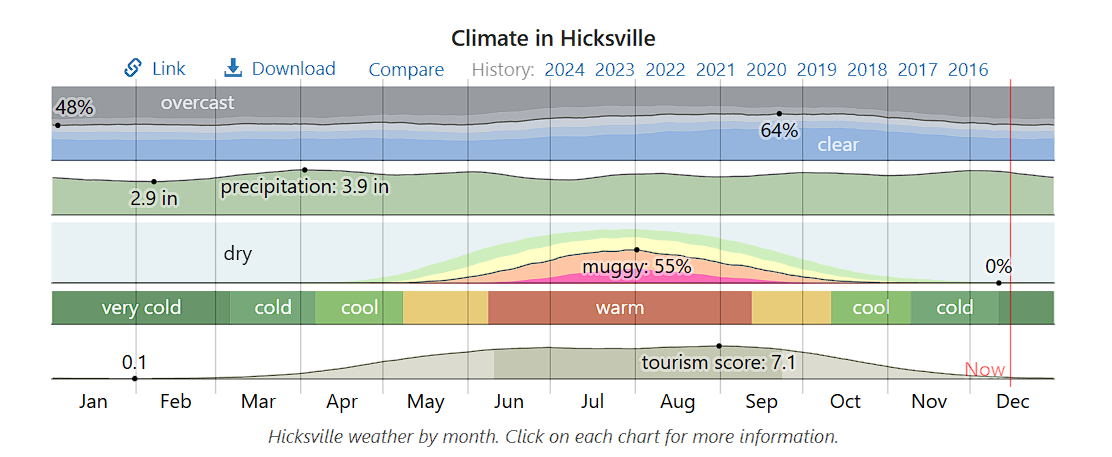
source: https://weatherspark.com/y/24564/Average-Weather-in-Hicksville-New-York-United-States-Year-Round

Dataset Creation on reasonable assumptions:
* Temperature (in Fahrenheit)
* Rainy conditions 
* Snowy conditions 
* Busy times 

Thresholds:
* Temperature <45 F
* Moderate or Heavy snow or rain
* Busier than usual


In [24]:
class PricingPredictor:
    def __init__(self):
        # Temperature thresholds (F)
        self.COLD_TEMP = 45
        self.HOT_TEMP = 73
        
        # Precipitation thresholds (inches)
        self.RAIN_THRESHOLD = 0.04
        self.SNOW_THRESHOLD = 1.0
        
        # Busyness threshold (percentage)
        self.BUSY_THRESHOLD = 70
        
        # Price adjustment factors
        self.MAX_PRICE_INCREASE = 1.3  
        self.MIN_PRICE_DECREASE = 0.9  
        
        
        self.model = DecisionTreeRegressor(max_depth=3)
        self.scaler = StandardScaler()
        
        
        self._train_model()

Data creation and reasoning based on weather patterns.

In [25]:
def _generate_training_data(self):
    
    n_samples = 5000
    
    # Generating synthetic features
    temperatures = np.random.normal(loc=55, scale=15, size=n_samples)  # Mean temp with variation
    precipitation = np.random.exponential(scale=0.1, size=n_samples)   # Rain/snow amounts
    busyness = np.random.normal(loc=50, scale=20, size=n_samples)     # Restaurant busyness
    
    # Required conditions for price adjustments
    cold_weather = temperatures < self.COLD_TEMP
    wet_weather = precipitation > self.RAIN_THRESHOLD
    busy_times = busyness > self.BUSY_THRESHOLD
    
    price_adjustments = np.ones(n_samples)
    price_adjustments[cold_weather & wet_weather & busy_times] *= self.MAX_PRICE_INCREASE
    price_adjustments[~(cold_weather | wet_weather | busy_times)] *= self.MIN_PRICE_DECREASE
    
    # Feature matrix
    X = np.column_stack([temperatures, precipitation, busyness])
    y = price_adjustments
    
    return X, y

PricingPredictor._generate_training_data = _generate_training_data

Training Model

In [26]:
def _train_model(self):
    X, y = self._generate_training_data()
    X_scaled = self.scaler.fit_transform(X)
    self.model.fit(X_scaled, y)
PricingPredictor._train_model = _train_model

Adjustment Factors

In [27]:

def predict_price_adjustment(self, temperature, precipitation, busyness):
    # Scale input features
    X = np.array([[temperature, precipitation, busyness]])
    X_scaled = self.scaler.transform(X)
    
    # Get prediction
    adjustment = self.model.predict(X_scaled)[0]
    
    #adjustment stays within bounds
    adjustment = max(self.MIN_PRICE_DECREASE, min(self.MAX_PRICE_INCREASE, adjustment))
    
    return adjustment

PricingPredictor.predict_price_adjustment = predict_price_adjustment

Finalised Price.

In [28]:
def get_final_price(self, base_price, temperature, precipitation, busyness):
    """Calculate final price based on conditions"""
    adjustment = self.predict_price_adjustment(temperature, precipitation, busyness)
    return round(base_price * adjustment, 2)

PricingPredictor.get_final_price = get_final_price

Test

In [29]:
predictor = PricingPredictor()
# Example usage
base_price = 10.0
temperature = 40.0
precipitation = 0.05
busyness = 80.0

final_price = predictor.get_final_price(base_price, temperature, precipitation, busyness)

print(f"Final price: ${final_price}")

Final price: $13.0
